# Classifying pulmonary diseases with transfer learning

<b>Contact info</b>
<br>
<b>Name:</b> Mardja Bueno, Ph.D.
<br>
<b>email:</b> mardja.bueno@gmail.com
<br>

## 1. Overview and goals

## 2. The dataset

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from PIL import Image
from pathlib import Path
import os

In [2]:
# create path for the folders where the training, test and validation images are
train_folders = 'Chest X ray images/train/' 
test_folders = 'Chest X ray images/test/'
val_folders = 'Chest X ray images/val/'

# create empty lists for train, test and val
total_train = {}
total_test = {}
total_val = {}

# iterate through the length of the list
for folder in os.listdir(train_folders):
    if not folder.startswith('.'): # so it doesn't open the .DS Store folder on Mac
        total_train[folder] = len(os.listdir(train_folders + folder))
    
for folder in os.listdir(test_folders):
    if not folder.startswith('.'):
        total_test[folder] = len(os.listdir(test_folders + folder))
    
for folder in os.listdir(val_folders):
    if not folder.startswith('.'):
        total_val[folder] = len(os.listdir(val_folders + folder))

# sum the number of images in each list
quantity_train = pd.DataFrame(list(total_train.items()), index = range(0,len(total_train)), columns = ['class','count'])
quantity_test = pd.DataFrame(list(total_test.items()), index = range(0,len(total_test)), columns = ['class','count'])
quantity_val = pd.DataFrame(list(total_val.items()), index = range(0,len(total_val)), columns = ['class','count'])

# print how many images we have in each dataset
print("Number of images in the training dataset : ", sum(total_train.values()))
print("Number of images in the testing dataset : ",sum(total_test.values()))
print("Number of images in the validation dataset : ",sum(total_val.values()))

Number of images in the training dataset :  6326
Number of images in the testing dataset :  771
Number of images in the validation dataset :  38


The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Normal/Pneumonia/Covid-19/Tuberculosis). A total of 7135 x-ray images are present.

## 3. Exploratory data analysis

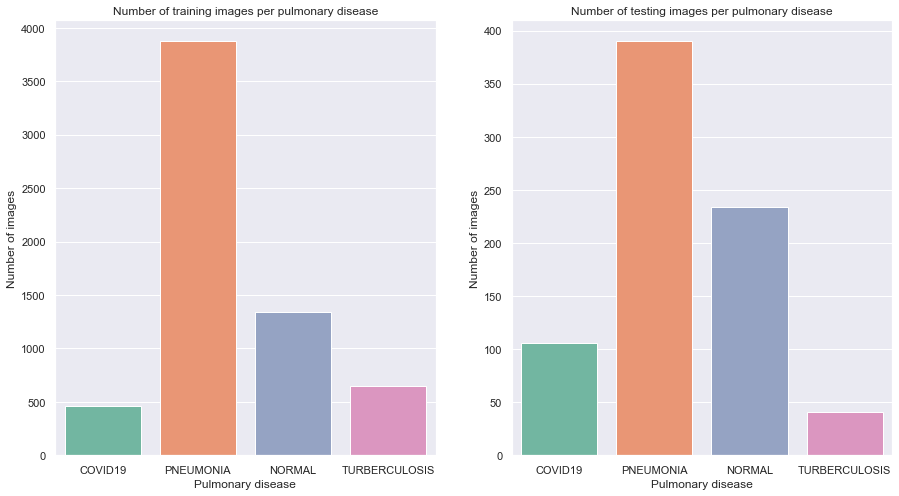

In [3]:
# create bar plots with the number of training and testing
# images in each folder per pulmonary disease
figure, ax = plt.subplots(1,2, figsize = (15,8))

sns.set_palette("Set2")

sns.barplot(x = 'class',y = 'count',data = quantity_train,ax = ax[0])
sns.barplot(x = 'class',y = 'count',data = quantity_test,ax = ax[1])


# set titles and labels
ax[0].set_title('Number of training images per pulmonary disease')
ax[0].set(xlabel = 'Pulmonary disease', ylabel = 'Number of images')

ax[1].set_title('Number of testing images per pulmonary disease')
ax[1].set(xlabel = 'Pulmonary disease', ylabel = 'Number of images')

plt.show()

## 4. Data preprocessing

In [4]:
!pip install keras
!pip install tensorflow

rescale: rescales images by the given factor
horizontal flip: randomly flip images horizontally.
validation_split: percentage of images reserved for validation.

In [5]:
# use tensorflow for the data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# use ImageDataGenerator to rescale and horizontally flip the images
train_image_gen = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip = True, 
                                     validation_split=0.2)

test_image_gen  = ImageDataGenerator(rescale=1./255)

valid_image_gen = ImageDataGenerator(rescale=1./255)



# transform the images from RGB to grayscale - is going to speed up model training later
# image size = 331 -> because of the pre trained model we're going to use
# flow training images in batches of 20 using train_datagen generator
train_generator = train_image_gen.flow_from_directory(directory=train_folders, 
                                                    target_size=(224, 224),
                                                    color_mode="grayscale",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=True,seed=42)


valid_generator = valid_image_gen.flow_from_directory(directory=val_folders, 
                                                    target_size=(224, 224),
                                                    color_mode="grayscale",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=True,seed=42)

test_generator = test_image_gen.flow_from_directory(directory=test_folders,
                                                  target_size=(224, 224),
                                                  color_mode="grayscale",
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=42)

Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


## 5. Building the model

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# creating the model
model= Sequential()

model.add(Conv2D(filters=128,strides= 1, kernel_size = (5,5), activation='relu', input_shape=(224,224,1,)))
model.add(MaxPool2D(3,3))
model.add(Conv2D(filters=64,kernel_size = (5,5),activation='relu'))
model.add(MaxPool2D(3,3))

model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Flatten())
model.add(Dense(2048,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dropout(.1))
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(.1))
model.add(Dense(32,activation='relu'))
model.add(Dense(4,activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 128)     3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 30)        17310     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 30)       0

In [7]:
# hyperparameters
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

# stop the training when there is no improvement after 3 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# fit the model
model.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,verbose= 1,
          validation_steps=STEP_SIZE_VALID,
          epochs=15, callbacks=early_stop)

Epoch 1/15
197/197 [==============================] - 719s 4s/step - loss: 0.7272 - accuracy: 0.7129 - val_loss: 0.8589 - val_accuracy: 0.6250
Epoch 2/15
197/197 [==============================] - 666s 3s/step - loss: 0.3646 - accuracy: 0.8642 - val_loss: 0.6535 - val_accuracy: 0.7188
Epoch 3/15
197/197 [==============================] - 671s 3s/step - loss: 0.2731 - accuracy: 0.9021 - val_loss: 0.5306 - val_accuracy: 0.7188
Epoch 4/15
197/197 [==============================] - 633s 3s/step - loss: 0.2653 - accuracy: 0.9082 - val_loss: 0.6662 - val_accuracy: 0.7812
Epoch 5/15
197/197 [==============================] - 634s 3s/step - loss: 0.2152 - accuracy: 0.9263 - val_loss: 0.6274 - val_accuracy: 0.7188
Epoch 6/15
197/197 [==============================] - 636s 3s/step - loss: 0.1827 - accuracy: 0.9390 - val_loss: 0.5367 - val_accuracy: 0.8125


In [8]:
# evaluate the model
model.evaluate(valid_generator,steps=STEP_SIZE_VALID)

1/1 [==============================] - 1s 1s/step - loss: 0.5180 - accuracy: 0.7500


[0.5180084705352783, 0.75]

In [16]:
# save the model
model.save("ChestXrayModel.h5")

## 6. Using a pre-trained model

In [30]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

# first pretrained model using Xception
base_pt_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_pt_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_pt_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
pt_model = keras.Model(inputs, outputs)

pt_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                             

In [32]:
# train the top layer
pt_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
pt_model.fit(train_generator, epochs=epochs, validation_data=valid_generator)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node 'model/sequential_3/random_flip/map/TensorArrayUnstack/TensorListFromTensor' defined at (most recent call last):
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
      self.io_loop.start()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-32-213a4af9d1e7>", line 9, in <module>
      pt_model.fit(train_generator, epochs=epochs, validation_data=valid_generator)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/layers/preprocessing/image_preprocessing.py", line 390, in call
      return self._format_output(self._batch_augment(inputs), is_dict)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/layers/preprocessing/image_preprocessing.py", line 416, in _batch_augment
      return self._map_fn(self._augment, inputs)
Node: 'model/sequential_3/random_flip/map/TensorArrayUnstack/TensorListFromTensor'
Specified a list with shape [150,150,3] from a tensor with shape [224,224,1]
	 [[{{node model/sequential_3/random_flip/map/TensorArrayUnstack/TensorListFromTensor}}]] [Op:__inference_train_function_95535]

In [22]:
# second pretrained model using InceptionResNetV2
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(331,331,3)
                     )

In [23]:
# freeze the layer so that the base_model's internal state will not change during training
base_model.trainable=False

In [24]:
pt_model = tf.keras.Sequential([
        base_model,  
        tf.keras.layers.BatchNormalization(renorm=True), #speeds up training
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(120, activation='softmax')
    ])

In [25]:
# compile the model
pt_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
# print the summary of the model
pt_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_411 (Ba  (None, 9, 9, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 512)               786944    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                      

In [27]:
# early stopping call back
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

In [28]:
# fit model
pt_model.fit(train_generator, 
             steps_per_epoch=STEP_SIZE_TRAIN, 
             validation_data=valid_generator, 
             validation_steps=STEP_SIZE_VALID, 
             epochs=15, 
             callbacks=[early])

Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/inception_resnet_v2/activation_203/Relu' defined at (most recent call last):
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
      self.io_loop.start()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-28-e40d2e632c73>", line 2, in <module>
      pt_model.fit(train_generator,
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/layers/core/activation.py", line 57, in call
      return self.activation(inputs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/activations.py", line 311, in relu
      return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 4992, in relu
      x = tf.nn.relu(x)
Node: 'sequential_2/inception_resnet_v2/activation_203/Relu'
input depth must be evenly divisible by filter depth: 1 vs 3
	 [[{{node sequential_2/inception_resnet_v2/activation_203/Relu}}]] [Op:__inference_train_function_84140]

In [19]:
# evaluate the model
pt_model.evaluate(valid_generator,steps=STEP_SIZE_VALID)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/inception_resnet_v2/activation/Relu' defined at (most recent call last):
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
      self.io_loop.start()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-19-7a89e592e2da>", line 2, in <module>
      pt_model.evaluate(valid_generator,steps=STEP_SIZE_VALID)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1499, in test_step
      y_pred = self(x, training=False)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/layers/core/activation.py", line 57, in call
      return self.activation(inputs)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/activations.py", line 311, in relu
      return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
    File "/Users/mardjabueno/opt/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 4992, in relu
      x = tf.nn.relu(x)
Node: 'sequential_1/inception_resnet_v2/activation/Relu'
input depth must be evenly divisible by filter depth: 1 vs 3
	 [[{{node sequential_1/inception_resnet_v2/activation/Relu}}]] [Op:__inference_test_function_47251]

In [ ]:
# save the model
pt_model.save("ChestXrayModel_pretrained.h5")